# Importing Dependencies
- Importing necessary libraries and modules.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from typing import Tuple
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, RegexTokenizer, StopWordsRemover, HashingTF, IDF, Binarizer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Step 1) Establishing Connection to the Master
- Initiating a SparkSession with customized configurations using SparkConf.
- Setting parameters tailored to individual user preferences is essential.

In [18]:
MASTER_IP = input("Insert your Master IP: ")

def create_connection(MASTER_IP: str) -> SparkSession:
  
  conf = SparkConf()\
    .setAppName('BugHunter')\
    .setMaster(f"spark://{MASTER_IP}:7077")\
    .set("spark.driver.host", f"{MASTER_IP}")\
    .set("spark.driver.port", "7077")\
    .set("spark.driver.bindAddress", "0.0.0.0")\
    .set("spark.executor.memory", "8g")\
    .set("spark.driver.memory", "8g")\
    .set("spark.task.maxFailures", "300")\
    .set("spark.shuffle.io.maxRetries", "100")\
    .set("spark.network.timeout", "60000000s")\
    .set("spark.executor.heartbeatInterval", "6s")\
    .set("spark.sql.shuffle.partitions", "8")\
    .set("spark.shuffle.compress", "true")\
    .set("spark.reducer.maxSizeInFlight", "256m")
  
  spark = SparkSession.builder\
    .config(conf=conf)\
    .getOrCreate()
  
  spark.sparkContext.setLogLevel("ERROR")
  
  return spark

spark = create_connection(MASTER_IP=MASTER_IP)

# Step 2) Data Loading
- Loading the dataset using Pandas and then converting it into a Spark DataFrame.

In [19]:

data = "method-p.csv"

def read_data(data: str, spark: SparkSession) -> DataFrame:
        print("\n 1) Step - Loading the dataset: ", data)
        
        df = pd.read_csv(data)
        loaded_data = spark.createDataFrame(df)
        
        return loaded_data

loaded_data = read_data(spark=spark, data=data)


 1) Step - Loading the dataset:  method-p.csv


# Step 3) Data Exploration
- Exploring dataset structure.
- Exploring the number of NA, empty values, NULL values, and duplicates.
- Exploring total bugs by Project, Hash, LongName, Parent.
- Exploring unique values and the percentage of zero values for every column in the dataset.

In [20]:
def explore_data(loaded_data: DataFrame):
    print("\n 2) Step - Exploring data: ")
    
    loaded_data.printSchema() 
    print(loaded_data.describe().toPandas()) 
    print(loaded_data.limit(15).toPandas())
    num_rows = loaded_data.count()
    print("Number of rows:", num_rows) 
    num_columns = len(loaded_data.columns)
    print("Number of columns:", num_columns) 
    
    nan_counts = loaded_data.count() - loaded_data.dropna().count()        
    print("Number of Na values:", nan_counts)  
    empty_count = sum(loaded_data.where(col(column) == "").count()
                        for column in loaded_data.columns)
    
    print("Number of empty values:", empty_count) 
    null_count = sum(loaded_data.filter(col(column).isNull()).count() for column in loaded_data.columns)
    print("Number of NULL values:", null_count) 
    duplicates_counts = loaded_data.count() - \
        loaded_data.dropDuplicates().count()
    
    print("Number of duplicates:", duplicates_counts) 
    
    print('Number of bugs by Project: ')
    project_bugs = loaded_data.groupBy("Project") \
                                .agg(F.sum("Number of Bugs").alias("Total_Bugs")) \
                                .orderBy(F.desc("Total_Bugs"))
    project_bugs.show(truncate=False)
    hash_bug_totals = loaded_data.groupBy("Hash") \
                            .agg(F.sum("Number of Bugs").alias("Total_Bugs")) \
                            .orderBy(F.desc("Total_Bugs"))
    print("Bug totals grouped by Hash:")
    hash_bug_totals.show(truncate=False)
    longname_bug_totals = loaded_data.groupBy("LongName") \
                                    .agg(F.sum("Number of Bugs").alias("Total_Bugs")) \
                                    .orderBy(F.desc("Total_Bugs"))
    print("Bug totals grouped by LongName:")
    longname_bug_totals.show(truncate=False)
    parent_bug_totals = loaded_data.groupBy("Parent") \
                                .agg(F.sum("Number of Bugs").alias("Total_Bugs")) \
                                .orderBy(F.desc("Total_Bugs"))
    print("Bug totals grouped by Parent:")
    parent_bug_totals.show(truncate=False)
    total_bugs = loaded_data.select(F.sum("Number of Bugs")).collect()[0][0]
    print("Total number of bugs:", total_bugs)
    
    unique_projects_count = loaded_data.select("Project").distinct().count()
    print("Number of unique values for Projects column:", unique_projects_count)
    print("Number of unique values for Hash column:", loaded_data.select("Hash").distinct().count())
    print("Number of unique values for LongName column:", loaded_data.select("LongName").distinct().count())
    print("Number of unique values for Parent column:", loaded_data.select("Parent").distinct().count())
    print("Unique values and count for Hash column:")
    loaded_data.groupBy("Hash").count().orderBy("count", ascending=False).show(truncate=False)
    print("Unique values and count for LongName column:")
    loaded_data.groupBy("LongName").count().orderBy("count", ascending=False).show(truncate=False)
    print("Unique values and count for Parent column:")
    loaded_data.groupBy("Parent").count().orderBy("count", ascending=False).show(truncate=False)
    
    for column in loaded_data.columns:
        print("Unique values and count for", column, "column (ordered by count in descending order):")
        loaded_data.groupBy(column).count().orderBy(desc("count")).show()
        total_rows = loaded_data.count()
        zero_count = loaded_data.where(col(column) == 0).count()
        zero_percentage = (zero_count / total_rows) * 100
        print(f"Percentage of zeros in {column} column: {zero_percentage:.2f}%")
        
explore_data(loaded_data)


 2) Step - Exploring data: 
root
 |-- Project: string (nullable = true)
 |-- Hash: string (nullable = true)
 |-- LongName: string (nullable = true)
 |-- Parent: string (nullable = true)
 |-- CC: double (nullable = true)
 |-- CCL: long (nullable = true)
 |-- CCO: long (nullable = true)
 |-- CI: long (nullable = true)
 |-- CLC: double (nullable = true)
 |-- CLLC: double (nullable = true)
 |-- LDC: long (nullable = true)
 |-- LLDC: long (nullable = true)
 |-- HCPL: double (nullable = true)
 |-- HDIF: double (nullable = true)
 |-- HEFF: double (nullable = true)
 |-- HNDB: double (nullable = true)
 |-- HPL: long (nullable = true)
 |-- HPV: long (nullable = true)
 |-- HTRP: double (nullable = true)
 |-- HVOL: double (nullable = true)
 |-- MI: double (nullable = true)
 |-- MIMS: double (nullable = true)
 |-- MISEI: double (nullable = true)
 |-- MISM: double (nullable = true)
 |-- McCC: long (nullable = true)
 |-- NL: long (nullable = true)
 |-- NLE: long (nullable = true)
 |-- NII: long (nul


# Step 4) Data Cleaning
- Removing duplicates.
- Removing columns with 100% zero values.
- Downsampling using the minimum values of the non-zero class of the target variable "Number of Bugs" to balance it.

In [21]:

def clean_data(loaded_data: DataFrame) -> DataFrame:
        print("\n 3) Step - Data Cleaning: ")
        
        print("\nNumber of rows before removing duplicates:", loaded_data.count()) 
        cleaned_data = loaded_data.dropDuplicates()
        num_duplicates_removed = loaded_data.count() - cleaned_data.count()
        print(f"Number of duplicates removed: {num_duplicates_removed}") 
        print("Number of rows after removing duplicates:", cleaned_data.count()) 
        
        # Remove columns 100% full of zero values
        num_cols_before = len(loaded_data.columns)
        print(f"Number of columns before the drop: {num_cols_before}")
        print("\nColumns to drop 100% of zero values: ")
        columns_to_drop = ["Hash",
        "WarningBlocker", "WarningInfo", "Android Rules",
         "Code Size Rules", "Finalizer Rules",
        "Comment Rules", "Coupling Rules", 
        "JavaBean Rules", "MigratingToJUnit4 Rules",
        "Migration13 Rules", "Migration14 Rules",
        "Migration15 Rules", "Vulnerability Rules"
        ]
        cleaned_data = cleaned_data.drop(*columns_to_drop)
        num_cols_after = len(cleaned_data.columns)
        print(f"Number of columns removed: {num_cols_before - num_cols_after}")
        print(f"Number of columns after the drop: {num_cols_after}")
        
        # Downsampling target variable
        num_zero_bugs = cleaned_data.filter(col("Number of Bugs") == 0).count()
        num_non_zero_bugs = cleaned_data.filter(col("Number of Bugs") != 0).count()
        min_rows_per_class = min(num_zero_bugs, num_non_zero_bugs)
        
        zero_bugs_sampled = cleaned_data.filter(col("Number of Bugs") == 0) \
                .sample(False, min_rows_per_class / num_zero_bugs)
        non_zero_bugs_sampled = cleaned_data.filter(col("Number of Bugs") != 0) \
                .sample(False, min_rows_per_class / num_non_zero_bugs)
        cleaned_data = zero_bugs_sampled.union(non_zero_bugs_sampled)
        
        print("\nDebug of downsampling: ")
        print(f"Balanced by min 'Number of Bugs' non-zero class: {min_rows_per_class}")
        print(f"Number of zero values on Number of Bugs column: {zero_bugs_sampled.count()}")
        print(f"Number of non-zero values on Number of Bugs column: {non_zero_bugs_sampled.count()}")

        return cleaned_data
  
cleaned_data = clean_data(loaded_data)


 3) Step - Data Cleaning: 

Number of rows before removing duplicates: 120167
Number of duplicates removed: 127
Number of rows after removing duplicates: 120040
Number of columns before the drop: 77

Columns to drop 100% of zero values: 
Number of columns removed: 14
Number of columns after the drop: 63

Debug of downsampling: 
Balanced by min 'Number of Bugs' non-zero class: 37720
Number of zero values on Number of Bugs column: 37667
Number of non-zero values on Number of Bugs column: 37720


# Step 5) Data Transformation
- Converting the target column 'Number of Bugs' into float type.
- Converting the 'Project' column from string type into a numeric vector type using StringIndexer and OneHotEncoding.
- Converting 'LongName' and 'Parent' columns from string type into a numeric vector:
* Using RegexTokenizer to split and tokenize words.
* Utilizing StopWordsRemover to eliminate redundant words resulting from splitting.
* Employing HashingTF to compute the term frequency.
* Applying IDF to calculate the inverted document frequency.
- Converting the target variable 'Number of Bugs' into a binary variable, 0.0 (no-bug) and 1.0 (bug).
- Transforming individual features into a combined numeric vector of features.

In [22]:
     
def transform_data(cleaned_data: DataFrame) -> DataFrame:
    print("\n 4) Step - Data Transformation: ")
    
    numeric_data = cleaned_data.columns[3:62]
    print(numeric_data)
    cleaned_data = cleaned_data.withColumn("Number of Bugs", 
                                        col("Number of Bugs").cast("double"))
    project_indexer = StringIndexer(inputCol="Project", 
                                    outputCol="ProjectIndex")
    project_encoder = OneHotEncoder(inputCol="ProjectIndex", 
                                    outputCol="ProjectVec")
    project_pipeline = Pipeline(stages=[project_indexer, project_encoder])
    project_encoded = project_pipeline.fit(cleaned_data).transform(cleaned_data)
    
    text_columns = ["LongName", "Parent"]
    text_pipeline_stages = []
    for column in text_columns:
        tokenizer = RegexTokenizer(pattern="[./();$<>]",
                                   inputCol=column, 
                                   outputCol=column +'_tokenized')
        stopwords_remover = StopWordsRemover(inputCol=column + '_tokenized',
                                            outputCol=column +'_no-stopwords', 
                                            stopWords=['v', 'l', 'z', 's', 'i', 'd', 'f', 'e', 'j'])
        hashingTF = HashingTF(inputCol=column + "_no-stopwords", 
                              outputCol=column + "_tf", 
                              numFeatures=1000)
        idf = IDF(inputCol=column + "_tf", 
                  outputCol=column + "_tfidf")
        text_pipeline_stages.extend([tokenizer, stopwords_remover, hashingTF, idf])
    
    text_pipeline = Pipeline(stages=text_pipeline_stages)
    text_data = text_pipeline.fit(project_encoded).transform(project_encoded)
    text_data.select(text_data.columns[-11:]).show()

        
    binarizer = Binarizer(threshold=0.0, 
                          inputCol="Number of Bugs", 
                          outputCol="Number of Bugs Binary")
    
    assembler = VectorAssembler(inputCols=["ProjectVec"] + 
                                ["LongName_tfidf"] + 
                                ["Parent_tfidf"] + 
                                numeric_data,
                                outputCol="features")
    
    final_pipeline = Pipeline(stages=[binarizer, assembler])
    assembled_data = final_pipeline.fit(text_data).transform(text_data)
    
    print('Debug transformed_data: ')
    assembled_data.printSchema()
    assembled_data.select(assembled_data.columns[-13:]).show()
    
    return assembled_data

assembled_data = transform_data(cleaned_data)


 4) Step - Data Transformation: 
['CC', 'CCL', 'CCO', 'CI', 'CLC', 'CLLC', 'LDC', 'LLDC', 'HCPL', 'HDIF', 'HEFF', 'HNDB', 'HPL', 'HPV', 'HTRP', 'HVOL', 'MI', 'MIMS', 'MISEI', 'MISM', 'McCC', 'NL', 'NLE', 'NII', 'NOI', 'CD', 'CLOC', 'DLOC', 'TCD', 'TCLOC', 'LLOC', 'LOC', 'NOS', 'NUMPAR', 'TLLOC', 'TLOC', 'TNOS', 'WarningCritical', 'WarningMajor', 'WarningMinor', 'Basic Rules', 'Brace Rules', 'Clone Implementation Rules', 'Controversial Rules', 'Design Rules', 'Empty Code Rules', 'Import Statement Rules', 'J2EE Rules', 'JUnit Rules', 'Jakarta Commons Logging Rules', 'Java Logging Rules', 'Migration Rules', 'Naming Rules', 'Optimization Rules', 'Security Code Guideline Rules', 'Strict Exception Rules', 'String and StringBuffer Rules', 'Type Resolution Rules', 'Unnecessary and Unused Code Rules']
+--------------+------------+--------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---


# Step 6) Data Scaling
- Scaling the data using MinMax scaler, which scales the data within the range (0; 1), primarily for educational purposes.
- RandomForest is less sensitive to scaling measures, making MinMax scaling less useful.
- It might be beneficial to implement RobustScaler to mitigate the presence of outliers, as it employs the median instead of the mean. However, this comes at the expense of significantly higher RAM usage.

In [23]:
   
def scale_data(assembled_data: DataFrame) -> DataFrame:
        print("\n 5) Step - Data Scaling: ")

        scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
        scaler_model = scaler.fit(assembled_data)
        scaled_data = scaler_model.transform(assembled_data)
        scaled_data.select('features').show(truncate=False)
        scaled_data.select('scaledFeatures').show(truncate=False)
            
        return scaled_data

scaled_data = scale_data(assembled_data)


 5) Step - Data Scaling: 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                

# Step 7) Data Splitting into Training and Test Sets
- Splitting the dataset into a training set (80%) and a test set (20%).

In [24]:

def split_data(scaled_data: DataFrame) -> Tuple[DataFrame, DataFrame]:
        print("\n 6) Step - Data Splitting: ")

        selected = scaled_data.select('scaledFeatures','Number of Bugs Binary')
        selected.show()
        
        train_data, test_data = selected.randomSplit([0.8, 0.2], seed=13)
        print("Number of rows into Training set: ", train_data.count())
        train_data.show()
        print("Number of rows into Test set: ", test_data.count())
        test_data.show()
        
        return train_data, test_data

train_data, test_data = split_data(scaled_data)


 6) Step - Data Splitting: 
+--------------------+---------------------+
|      scaledFeatures|Number of Bugs Binary|
+--------------------+---------------------+
|(2073,[4,237,317,...|                  0.0|
|(2073,[4,237,317,...|                  0.0|
|(2073,[4,63,237,6...|                  0.0|
|(2073,[0,102,129,...|                  0.0|
|(2073,[1,216,237,...|                  0.0|
|(2073,[5,179,237,...|                  0.0|
|(2073,[3,261,306,...|                  0.0|
|(2073,[3,223,261,...|                  0.0|
|(2073,[3,66,242,2...|                  0.0|
|(2073,[0,116,129,...|                  0.0|
|(2073,[0,129,263,...|                  0.0|
|(2073,[0,28,47,12...|                  0.0|
|(2073,[0,67,129,2...|                  0.0|
|(2073,[0,129,356,...|                  0.0|
|(2073,[0,129,180,...|                  0.0|
|(2073,[0,50,129,3...|                  0.0|
|(2073,[0,67,129,2...|                  0.0|
|(2073,[0,129,214,...|                  0.0|
|(2073,[5,79,138,1...|    


# Step 8) Model Training
- Training the models using RandomForestClassifier with entropy impurity measure to balance the importance of classes based on their distribution.
- Cross-validating the models on the training set, with parallelism set to divide cross-validation data into partitions among workers.
- Selecting the best model from the cross-validation process using parameters such as max depth and number of trees set in the ParamGridBuilder.

In [25]:
def fit_model(train_data: DataFrame) -> DataFrame:
        print("\n 7) Step - Model Training: ")

        random_forest = RandomForestClassifier(labelCol="Number of Bugs Binary", 
                                               featuresCol='scaledFeatures', 
                                               impurity='entropy')
        best_model = random_forest.fit(train_data)
        
        param_grid = ParamGridBuilder() \
                .addGrid(random_forest.maxDepth, [5, 10, 15, 20]) \
                .addGrid(random_forest.numTrees, [5, 50, 100, 200]) \
                .build()
                
        evaluator = BinaryClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                  metricName="areaUnderROC")

        crossval = CrossValidator(estimator=random_forest,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5,
                                parallelism=8)
        
        cv_model = crossval.fit(train_data)
        avg_metrics = cv_model.avgMetrics
        print("ROC AUC results from cv on training set:", avg_metrics)

        best_model = cv_model.bestModel

        print("Best model parameters:")
        print("maxDepth:", best_model._java_obj.getMaxDepth())
        print("numTrees:", best_model._java_obj.getNumTrees())
        
        return best_model

best_model = fit_model(train_data)


 7) Step - Model Training: 
ROC AUC results from cv on training set: [0.6517759730449393, 0.6706009744883835, 0.6724555315074163, 0.6726719140113266, 0.6847199754984115, 0.701980965993191, 0.7028230483282423, 0.7032755545679932, 0.704510544378907, 0.726055862325123, 0.7271120300119498, 0.7274113617765658, 0.7200279294854258, 0.7443633820222703, 0.7460031006664918, 0.7462331163678206]
Best model parameters:
maxDepth: 20
numTrees: 200


# Step 9) Model Evaluation
- Assessing the best model's performance using metrics including F1 score, accuracy, precision, and AUC.

In [26]:
           
def evaluate_model(best_model: RandomForestClassificationModel, test_data: DataFrame) -> DataFrame:
        print("\n 8) Step - Model Evaluation: ")

        predictions = best_model.transform(test_data)
        predictions.show(10)
        
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                         metricName="f1")
        f1_score = evaluator_f1.evaluate(predictions)
        print(f"F1 Score:{f1_score:.4f}") 
        
        evaluator_acc = MulticlassClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                          metricName="accuracy")
        accuracy = evaluator_acc.evaluate(predictions)
        print(f"Accuracy: {accuracy:.4f}") 
        
        evaluator_recall = MulticlassClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                             metricName="weightedRecall")
        recall = evaluator_recall.evaluate(predictions)
        print(f"Recall: {recall:.4f}")
        
        evaluator_precision = MulticlassClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                                metricName="weightedPrecision")
        precision = evaluator_precision.evaluate(predictions)
        print(f"Precision: {precision:.4f}") 
        
        evaluator_roc = BinaryClassificationEvaluator(labelCol="Number of Bugs Binary", 
                                                            metricName="areaUnderROC")
        roc = evaluator_roc.evaluate(predictions)
        print(f"ROC AUC: {roc:.4f}")
            
        return predictions
            
predictions = evaluate_model(best_model, test_data)


 8) Step - Model Evaluation: 
+--------------------+---------------------+--------------------+--------------------+----------+
|      scaledFeatures|Number of Bugs Binary|       rawPrediction|         probability|prediction|
+--------------------+---------------------+--------------------+--------------------+----------+
|(2073,[0,14,129,3...|                  0.0|[76.0649829420884...|[0.38032491471044...|       1.0|
|(2073,[0,15,129,2...|                  0.0|[90.5059630806250...|[0.45252981540312...|       1.0|
|(2073,[0,17,129,1...|                  0.0|[170.618268162254...|[0.85309134081127...|       0.0|
|(2073,[0,20,67,12...|                  0.0|[132.225197358490...|[0.66112598679245...|       0.0|
|(2073,[0,20,67,12...|                  0.0|[183.876644174720...|[0.91938322087360...|       0.0|
|(2073,[0,20,67,12...|                  0.0|[94.4313327618556...|[0.47215666380927...|       1.0|
|(2073,[0,20,67,12...|                  0.0|[185.883561036458...|[0.92941780518229...| 


# Step 10) Model Performance Visualization
- Visualizing the performance of the best model through metrics such as the Confusion Matrix, ROC Curve, and the Top 15 most important features.




 9) Step - Model Performance Visualization: 


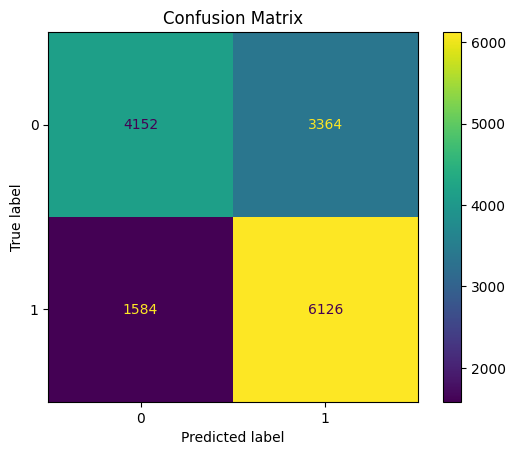

True Negative: 4152
False Positive: 3364
False Negative: 1584
True Positive: 6126


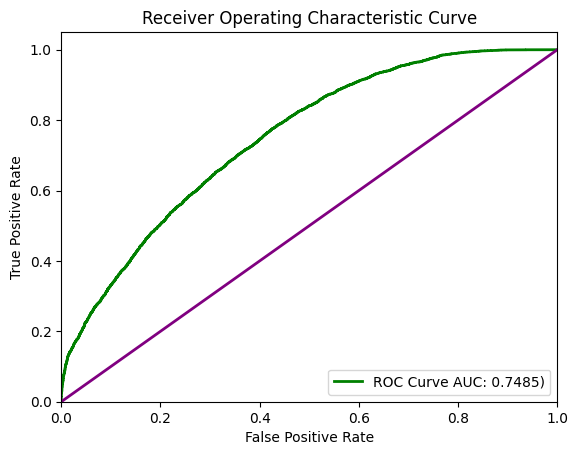

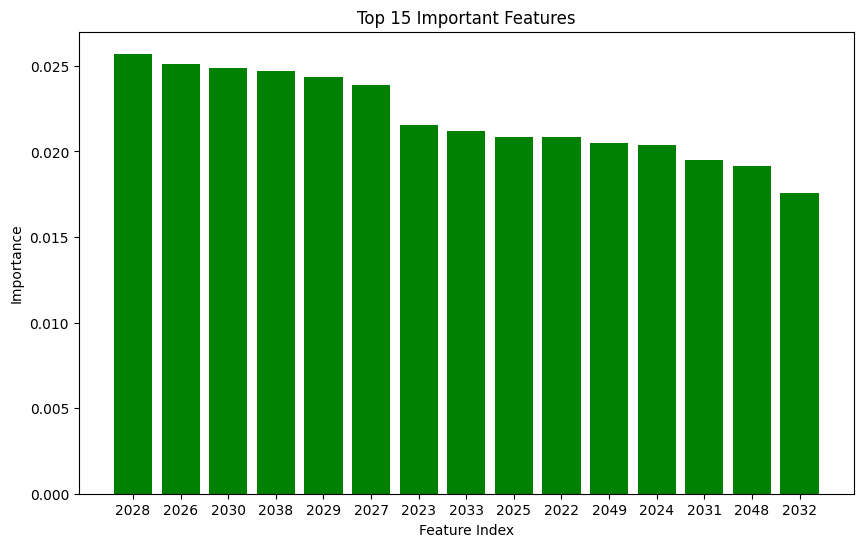


Top 15 Important Features:
Feature 2028: 0.0257
Feature 2026: 0.0251
Feature 2030: 0.0249
Feature 2038: 0.0247
Feature 2029: 0.0244
Feature 2027: 0.0239
Feature 2023: 0.0216
Feature 2033: 0.0212
Feature 2025: 0.0209
Feature 2022: 0.0208
Feature 2049: 0.0205
Feature 2024: 0.0204
Feature 2031: 0.0195
Feature 2048: 0.0192
Feature 2032: 0.0176


In [27]:
def plot_results_model(predictions: DataFrame):
    print("\n 9) Step - Model Performance Visualization: ")

    y_true = predictions.select("Number of Bugs Binary").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                            display_labels=[0, 1])
    display_matrix.plot()
    plt.title("Confusion Matrix")
    plt.show()
    
    true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()
    print("True Negative:", true_neg)
    print("False Positive:", false_pos)
    print("False Negative:", false_neg)
    print("True Positive:", true_pos)
    
    y_prob = predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()
    false_pred, true_pred, _ = roc_curve(y_true, y_prob)
    roc_area = auc(false_pred, true_pred)
    plt.plot(false_pred, true_pred, color="green", lw=2, 
             label=f"ROC Curve AUC: {roc_area:.4f})")
    plt.plot([0, 1], [0, 1], color="purple", lw=2, linestyle="-")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    importance_features = best_model.featureImportances.toArray()
    sorted_list_indices = importance_features.argsort()[::-1]
    top_features_indices = sorted_list_indices[:15]
    top_features_importance = importance_features[top_features_indices]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_features_importance)), top_features_importance, color = 'green')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Top 15 Important Features')
    plt.xticks(range(len(top_features_importance)), top_features_indices)
    plt.show()  
    
    print("\nTop 15 Important Features:")
    for i in range(15):
        feature_index = sorted_list_indices[i]
        feature_importance = importance_features[feature_index]
        print(f"Feature {feature_index}: {feature_importance:.4f}")  

plot_results_model(predictions)

# Stop the connection to the Master

In [28]:
spark.stop()